In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gc
import time
import scipy.sparse
import scipy.sparse.linalg

# Physical parameters
mass = 1.0
hbar = (1/5)**0.5
I_0 = 10.0
E = 2.0
V0 = 3.0 
xi = 10.0

# Energy range
n_energies = 24
energy_min, energy_max = 1.5, 2.3

# Channel indices
j_max = 5      # Increase for more channels if desired
j_vals = np.arange(-j_max, j_max+1)

# Adding a small positive imaginary part to E to regularize the Green's function
E_complex = E + 1j * 1e-8

# Compute k_j for each channel
k_vals = np.zeros(len(j_vals), dtype=complex)
for idx, j in enumerate(j_vals):
    val = 2 * mass * (E_complex - ((j ** 2) * (hbar**2) / (2 * I_0)))
    
#     if val >= 0:
#         k_vals[idx] = np.sqrt(val)
#     else:
#         k_vals[idx] = 1j * np.sqrt(-val)

    k_vals[idx] = np.sqrt(val)

# Spatial grid
N = 1500
L = 40.0
x = np.linspace(-L, L, N)
dx = x[1] - x[0]

# print(x)  
# print(k_vals)   

In [2]:
# --- Parameters for the Non-Uniform Grid ---
# place ~150 points in each of the 3 spike regions.
N_fine_per_spike = 150
width_fine_region = 6.0 # A region of +/- 3.0 around each spike center

# Resolution in the COARSE regions
N_coarse_inner_region = 50
N_coarse_outer_region = 75

# --- Define the grid segments ---
spike_centers = [-10.0, 0.0, 10.0]
sim_boundary = L

# Create each segment using np.linspace
x1 = np.linspace(-sim_boundary, spike_centers[0] - width_fine_region/2, N_coarse_outer_region, endpoint=False)
x2 = np.linspace(spike_centers[0] - width_fine_region/2, spike_centers[0] + width_fine_region/2, N_fine_per_spike, endpoint=False)
x3 = np.linspace(spike_centers[0] + width_fine_region/2, spike_centers[1] - width_fine_region/2, N_coarse_inner_region, endpoint=False)
x4 = np.linspace(spike_centers[1] - width_fine_region/2, spike_centers[1] + width_fine_region/2, N_fine_per_spike, endpoint=False)
x5 = np.linspace(spike_centers[1] + width_fine_region/2, spike_centers[2] - width_fine_region/2, N_coarse_inner_region, endpoint=False)
x6 = np.linspace(spike_centers[2] - width_fine_region/2, spike_centers[2] + width_fine_region/2, N_fine_per_spike, endpoint=False)
x7 = np.linspace(spike_centers[2] + width_fine_region/2, sim_boundary, N_coarse_outer_region) # Last one includes endpoint

# --- Stitch the segments together ---
x = np.concatenate([x1, x2, x3, x4, x5, x6, x7])
N = len(x)

print(f"Total points in non-uniform grid (New N): {N}")

# Optional: Visualize the grid point density
# plt.figure(figsize=(10, 2))
# plt.plot(x, np.zeros_like(x), '|')
# plt.title("Visualization of Non-Uniform Grid Points")
# plt.show()

Total points in non-uniform grid (New N): 700


In [3]:
# Calculate the local spacing for each point in the non-uniform grid
dx_vec = np.gradient(x)

In [4]:
# Green's function for channel j
def greens_function(xn, xm, kj):
    # Outgoing Green's function as per equation
    return -(1j * mass) / (hbar**2 * kj) * np.exp(1j * kj * np.abs(xn - xm))

# Coupled-channel potential (sum of three Gaussians)
def potential_triplet(x_p, xi=xi):
    m_vals = np.array([-1, 0, 1])
    return (V0)*(np.sum([np.exp(-(x_p - m*xi)**2) for m in m_vals]))


In [5]:
# V = np.zeros(N)
# for xn_idx, xn in enumerate(x):
#     V[xn_idx] = potential_triplet(xn)
# plt.plot(x,V)
# print(V[300])
# print(x[300])


In [6]:
# n_ch = len(j_vals)
# dim = N * n_ch
# K = np.zeros((dim, dim), dtype=np.complex128)

# # For each j,x pair, couple only j to j+1/j-1 via the potential
# for j_idx, j in enumerate(j_vals):
#     kj = k_vals[j_idx]
#     for xn_idx, xn in enumerate(x):
#         row_idx = j_idx * N + xn_idx
#         # Coupling to j-1
#         l = j - 1
#         if l in j_vals:
#             l_idx = np.where(j_vals == l)[0][0]
#             for xm_idx, xm in enumerate(x):
#                 col_idx = l_idx * N + xm_idx
#                 G_val = greens_function(xn, xm, kj)
#                 V_val = potential_triplet(xm)
#                 K[row_idx, col_idx] += G_val * V_val * dx
#         # Coupling to j+1
#         l = j + 1
#         if l in j_vals:
#             l_idx = np.where(j_vals == l)[0][0]
#             for xm_idx, xm in enumerate(x):
#                 col_idx = l_idx * N + xm_idx
#                 G_val = greens_function(xn, xm, kj)
#                 V_val = potential_triplet(xm)
#                 K[row_idx, col_idx] += G_val * V_val * dx


In [7]:
# We can define width as being within ~3 standard deviations of each peak.
# Since our Gaussians are exp(-x^2), the standard deviation is 1/sqrt(2).
xi = 10.0
window_half_width = 3.0 # A reasonable window around each peak

potential_mask = (np.abs(x - (-xi)) < window_half_width) | \
                 (np.abs(x - 0)   < window_half_width) | \
                 (np.abs(x - (xi))  < window_half_width)

# Get the actual integer indices of the grid points within these windows
active_xm_indices = np.where(potential_mask)[0]

print(f"Original number of spatial points to integrate over: {N}")
print(f"Optimized number of spatial points: {len(active_xm_indices)}")


n_ch = len(j_vals)
dim = N * n_ch
K = np.zeros((dim, dim), dtype=np.complex128)
# Pre-calculate the potential values ONLY at the active sites
V_vals_active = np.array([potential_triplet(xm) for xm in x[active_xm_indices]])

# For each j,x pair, couple only j to j+1/j-1 via the potential
for j_idx, j in enumerate(j_vals):
    kj = k_vals[j_idx]
    for xn_idx, xn in enumerate(x):
        row_idx = j_idx * N + xn_idx
        # Coupling to j-1
        l = j - 1
        if l in j_vals:
            l_idx = np.where(j_vals == l)[0][0]
            # OPTIMIZED LOOP Iterate only over the pre-calculated active indices
            for i, xm_idx in enumerate(active_xm_indices):
                xm = x[xm_idx]
                col_idx = l_idx * N + xm_idx
                G_val = greens_function(xn, xm, kj)
                # Use the pre-calculated potential value
                K[row_idx, col_idx] += G_val * V_vals_active[i] * dx_vec[xm_idx]                
        # Coupling to j+1
        l = j + 1
        if l in j_vals:
            l_idx = np.where(j_vals == l)[0][0]
            # OPTIMIZED LOOP Iterate only over the pre-calculated active indices
            for i, xm_idx in enumerate(active_xm_indices):
                xm = x[xm_idx]
                col_idx = l_idx * N + xm_idx
                G_val = greens_function(xn, xm, kj)
                # Use the pre-calculated potential value
                K[row_idx, col_idx] += G_val * V_vals_active[i] * dx_vec[xm_idx]

# print("\nK-Matrix construction complete with optimization.")                 

Original number of spatial points to integrate over: 700
Optimized number of spatial points: 447


In [8]:
# cond_K = np.linalg.cond(K)
# print(f"Condition number of K: {cond_K}")


In [9]:
# print(K[np.nonzero(K)])

In [10]:
# print((K.shape))

In [11]:
# print(np.where(j_vals == 0)[0][0])

In [12]:
# Incident wave: only in the j=0 channel
phi = np.zeros(dim, dtype=np.complex128)
inc_channel = np.where(j_vals == 0)[0][0]
for xn_idx, xn_val in enumerate(x):
    idx = inc_channel * N + xn_idx
    phi[idx] = np.exp(1j * k_vals[inc_channel] * xn_val)

# inc_channel2 = np.where(j_vals == 1)[0][0]
# for xn_idx, xn_val in enumerate(x):
#     idx = inc_channel2 * N + xn_idx
#     phi[idx] = np.exp(1j * k_vals[inc_channel2] * xn_val)

# Solve (I - K) psi = phi
A = np.eye(dim, dtype=np.complex128) - K
psi = np.linalg.solve(A, phi)
psi_mat = psi.reshape((n_ch, N))  # shape: (num_channels, N)



D:\Kaustubh\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


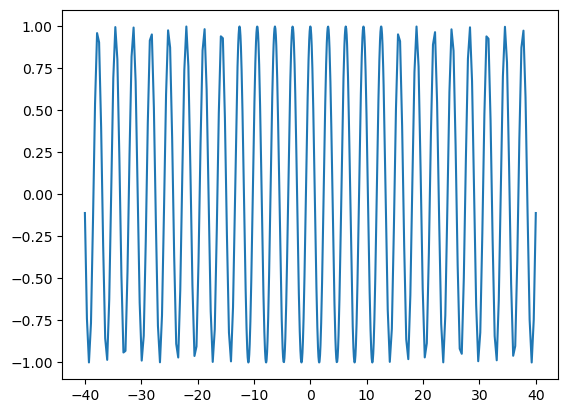

In [13]:
phi = phi.reshape((n_ch,N))
# plt.plot(x, phi[15])
plt.plot(x,phi[5])

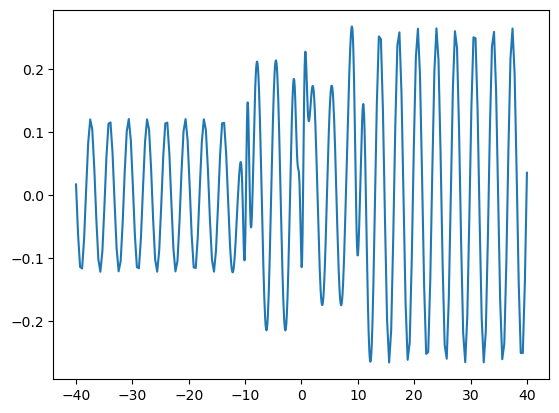

In [14]:
plt.plot(x,psi_mat[0])

In [15]:
# CHECK THE CONDITION NUMBER HERE
# cond_A = np.linalg.cond(A)
# print(f"Condition number of A: {cond_A}")

# # If cond_A is huge (e.g., > 1e16), the solution will be unreliable
# psi = np.linalg.solve(A, phi)
# psi_mat = psi.reshape((n_ch, N))

In [16]:
# # --- Benchmark the Solvers ---
# # Assume 'A' is your final (dense) matrix to be solved
# # Assume 'phi' is your right-hand-side vector

# print("--- Solver Benchmark ---")

# # 1. Time the dense solver
# print("Timing np.linalg.solve (dense)...")
# start_dense = time.time()
# psi_dense = np.linalg.solve(A, phi)
# end_dense = time.time()
# dense_time = end_dense - start_dense
# print(f"--> Dense solver time: {dense_time:.4f} seconds")

# # 2. Convert A to a sparse format and time the sparse solver
# # Compressed Sparse Column (CSC) format is generally good for solvers.
# print("\nConverting matrix to sparse format...")
# A_sparse = scipy.sparse.csc_matrix(A)

# print("Timing scipy.sparse.linalg.spsolve (sparse)...")
# start_sparse = time.time()
# psi_sparse = scipy.sparse.linalg.spsolve(A_sparse, phi)
# end_sparse = time.time()
# sparse_time = end_sparse - start_sparse
# print(f"--> Sparse solver time: {sparse_time:.4f} seconds")

# # 3. Compare results
# if sparse_time < dense_time:
#     print(f"\nConclusion: The sparse solver is {dense_time/sparse_time:.2f}x faster for this matrix.")
# else:
#     print(f"\nConclusion: The dense solver is {sparse_time/dense_time:.2f}x faster for this matrix.")

#### Treating open and closed channels differently

In [17]:
# Choose x regions well outside the scattering region
refl_mask = x < -L/2
trans_mask = x > L/2

r_coeffs = np.zeros(n_ch, dtype=np.complex128)
t_coeffs = np.zeros(n_ch, dtype=np.complex128)

for idx_ch, kj in enumerate(k_vals):
    psi_refl = psi_mat[idx_ch, refl_mask]
    x_refl = x[refl_mask]
    M_refl = np.vstack([np.exp(1j*kj*x_refl), np.exp(-1j*kj*x_refl)]).T
    coeffs_refl, _, _, _ = np.linalg.lstsq(M_refl, psi_refl, rcond=None)
    r_coeffs[idx_ch] = coeffs_refl[1]  # reflected amplitude
    

    psi_trans = psi_mat[idx_ch, trans_mask]
    x_trans = x[trans_mask]
#     ratios = psi_trans / np.exp(1j*kj*x_trans) 
#     t_coeffs[idx_ch] = np.mean(ratios)
    M_trans = np.vstack([np.exp(1j*kj*x_trans), np.exp(-1j*kj*x_trans)]).T
    coeffs_trans, _, _, _ = np.linalg.lstsq(M_trans, psi_trans, rcond=None)
    t_coeffs[idx_ch] = coeffs_trans[0]   


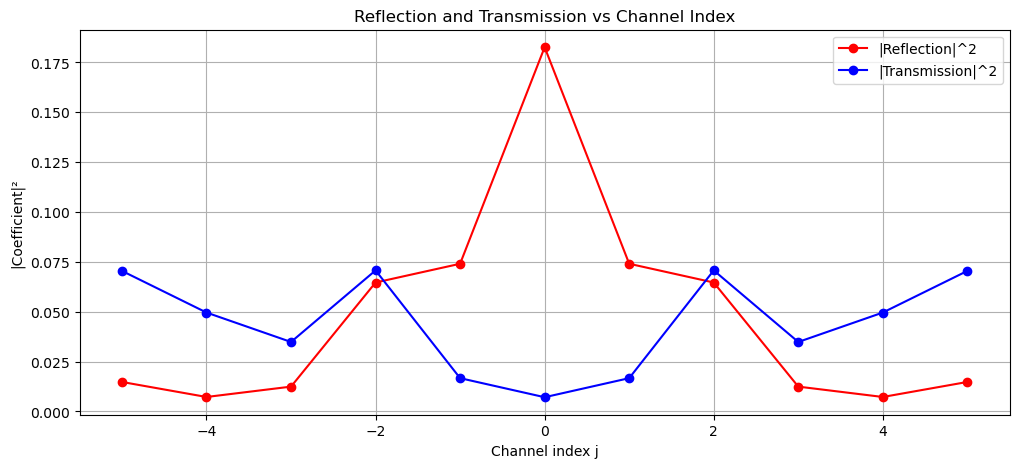

In [18]:
import matplotlib.pyplot as plt

# Magnitude squared of reflection and transmission in each channel
plt.figure(figsize=(12,5))
plt.plot(j_vals, np.abs(r_coeffs)**2, 'ro-', label='|Reflection|^2')
plt.plot(j_vals, np.abs(t_coeffs)**2, 'bo-', label='|Transmission|^2')
plt.xlabel('Channel index j')
plt.ylabel('|Coefficient|²')
plt.legend()
plt.title('Reflection and Transmission vs Channel Index')
plt.grid(True)
plt.show()


In [19]:
print(np.sum(np.abs(r_coeffs)**2) + np.sum(np.abs(t_coeffs)**2)) 

1.0209892116569494


got 5 decimal place accuracy in above between optimized and non optimized probabilities

In [ ]:
import matplotlib.pyplot as plt

## Wavefunction Visualization
plt.figure(figsize=(16, 32))

for ch_idx, j in enumerate(j_vals):
    psi_ch = psi_mat[ch_idx]
    plt.subplot(((len(j_vals)//2) + 1), 2, ch_idx+1)
    plt.plot(x, psi_ch.real, 'b', label=f'Real j={j}')
    plt.plot(x, psi_ch.imag, 'r--', label=f'Imag j={j}')
    plt.xlabel('x')
    plt.ylabel('ψ(x)')    
    plt.title(f'Channel {j}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


### STATISTICS

In [14]:
def calculate_scattering_for_incident_channel(inc_channel_idx, k_vals, j_vals, x, dx, N, n_ch, K):
    """
    Calculate scattering coefficients for a specific incident channel
    Returns reflection and transmission coefficients for all channels
    """
    dim = N * n_ch
    
    # Incident wave in specified channel
    phi = np.zeros(dim, dtype=np.complex128)
    for xn_idx, xn_val in enumerate(x):
        idx = inc_channel_idx * N + xn_idx
        phi[idx] = np.exp(1j * k_vals[inc_channel_idx] * xn_val)
    
    # Solve linear system
    A = np.eye(dim, dtype=np.complex128) - K
    psi = np.linalg.solve(A, phi)
    psi_mat = psi.reshape((n_ch, N))
    
    # Extract coefficients
    refl_mask = x < -L/2
    trans_mask = x > L/2
    
    r_coeffs = np.zeros(n_ch, dtype=np.complex128)
    t_coeffs = np.zeros(n_ch, dtype=np.complex128)
    
    for idx_ch, kj in enumerate(k_vals):
        psi_refl = psi_mat[idx_ch, refl_mask]
        x_refl = x[refl_mask]
        M_refl = np.vstack([np.exp(1j*kj*x_refl), np.exp(-1j*kj*x_refl)]).T
        coeffs_refl, _, _, _ = np.linalg.lstsq(M_refl, psi_refl, rcond=None)
        r_coeffs[idx_ch] = coeffs_refl[1]  # reflected amplitude
        
        psi_trans = psi_mat[idx_ch, trans_mask]
        x_trans = x[trans_mask]
#         ratios = psi_trans / np.exp(1j*kj*x_trans)
#         t_coeffs[idx_ch] = np.mean(ratios)
        M_trans = np.vstack([np.exp(1j*kj*x_trans), np.exp(-1j*kj*x_trans)]).T
        coeffs_trans, _, _, _ = np.linalg.lstsq(M_trans, psi_trans, rcond=None)
        t_coeffs[idx_ch] = coeffs_trans[0]   

    
    # Return as f_coeffs array: [channel, 0=reflection/1=transmission]
    f_coeffs = np.zeros((n_ch, 2), dtype=np.complex128)
    f_coeffs[:, 0] = r_coeffs
    f_coeffs[:, 1] = t_coeffs
    
    del K
    del A
    # Manually trigger garbage collection
    gc.collect()
    
    return f_coeffs


In [15]:
def construct_full_s_matrix(all_f_coeffs, k_vals, j_vals):
    """
    Construct the full S-matrix from f-coefficients
    S-matrix structure: (T R)
                       (R T)
    """
    # Get open channel indices (real k values)
    open_channel_indices = [i for i in range(len(j_vals)) if np.imag(k_vals[i]) < 1e-10]
    n_open_channels = len(open_channel_indices)
    
    print(f"Open channels: {[j_vals[i] for i in open_channel_indices]}")
    print(f"Number of open channels: {n_open_channels}")
    
    # Initialize S-matrix (2N x 2N for N open channels)
    S_matrix = np.zeros((2*n_open_channels, 2*n_open_channels), dtype=np.complex128)
    
    # Fill the S-matrix
    for i, inc_channel in enumerate(open_channel_indices):
        if inc_channel in all_f_coeffs:
            f_coeffs = all_f_coeffs[inc_channel]
            
            for j, out_channel in enumerate(open_channel_indices):
                # Extract coefficients
                r_coeff = f_coeffs[out_channel, 0]  # reflection
                t_coeff = f_coeffs[out_channel, 1]  # transmission
                
                # Fill 2x2 block: (T R)
                #                (R T)
                S_matrix[2*j, 2*i] = t_coeff      # T_ji
                S_matrix[2*j, 2*i+1] = r_coeff    # R_ji  
                S_matrix[2*j+1, 2*i] = r_coeff    # R_ji
                S_matrix[2*j+1, 2*i+1] = t_coeff  # T_ji
    
    return S_matrix

# Construct S-matrix for current energy
# S_matrix = construct_full_s_matrix(all_f_coeffs, k_vals, j_vals)
# print(f"S-matrix shape: {S_matrix.shape}")

# # Check unitarity
# S_dagger = S_matrix.conj().T
# unitarity_check = S_dagger @ S_matrix
# identity_check = np.allclose(unitarity_check, np.eye(S_matrix.shape[0]), rtol=1e-3, atol=1e-3)
# print(f"S-matrix unitarity check: {'PASSED' if identity_check else 'FAILED'}")
# print(f"Max deviation from identity: {np.max(np.abs(unitarity_check - np.eye(S_matrix.shape[0]))):.6f}")


In [16]:
def build_K_matrix(k_vals, j_vals, x, dx, n_ch):
    """
    Construct the coupled-channel K matrix for given k_vals, channels, and spatial grid.
    Returns the K matrix.
    """
    N = len(x)
    dim = n_ch * N
    K = np.zeros((dim, dim), dtype=np.complex128)

    for j_idx, j in enumerate(j_vals):
        kj = k_vals[j_idx]
        for xn_idx, xn in enumerate(x):
            row_idx = j_idx * N + xn_idx
            # Coupling to j-1
            l = j - 1
            if l in j_vals:
                l_idx = np.where(j_vals == l)[0][0]
                for xm_idx, xm in enumerate(x):
                    col_idx = l_idx * N + xm_idx
                    G_val = greens_function(xn, xm, kj)
                    V_val = potential_triplet(xm)
                    K[row_idx, col_idx] += G_val * V_val * dx
            # Coupling to j+1
            l = j + 1
            if l in j_vals:
                l_idx = np.where(j_vals == l)[0][0]
                for xm_idx, xm in enumerate(x):
                    col_idx = l_idx * N + xm_idx
                    G_val = greens_function(xn, xm, kj)
                    V_val = potential_triplet(xm)
                    K[row_idx, col_idx] += G_val * V_val * dx
    return K


In [17]:
def calculate_k_values_for_energy(E_val, j_vals, mass, hbar, I_0):
    """Calculate k values for given energy"""
    k_vals_new = np.zeros(len(j_vals), dtype=complex)
    for idx, j in enumerate(j_vals):
        val = 2 * mass * (E_val - ((j ** 2) * (hbar**2) / (2 * I_0)))
        if val >= 0:
            k_vals_new[idx] = np.sqrt(val)
        else:
            k_vals_new[idx] = 1j * np.sqrt(-val)
    return k_vals_new

def single_energy_s_matrix(E_val, j_vals, x, dx, N, n_ch, mass, hbar, I_0):
    """Calculate S-matrix for a single energy with K matrix construction"""
    # Calculate k values for this energy
    k_vals_E = calculate_k_values_for_energy(E_val, j_vals, mass, hbar, I_0)
    
    # Build K matrix for this energy
    print(f"Building K matrix for E = {E_val:.3f}")
    K = build_K_matrix(k_vals_E, j_vals, x, dx, n_ch)
    
    # Get open channels for this energy
    open_channel_indices = [i for i in range(len(j_vals)) if np.imag(k_vals_E[i]) < 1e-10]
    
    # Only calculate for incident channels that are open and in range -3 to +3
    incident_channels = []
    inc_channel_range = range(-j_max, j_max + 1) # (-3,4) for n_ch = 8.
    for j_inc in inc_channel_range:
        if j_inc in j_vals:
            idx = np.where(j_vals == j_inc)[0][0]
            if idx in open_channel_indices:
                incident_channels.append(idx)
    
    print(f"  Open incident channels: {[j_vals[i] for i in incident_channels]}")
    
    # Calculate f-coefficients for all incident channels
    all_f_coeffs_E = {}
    for inc_idx in incident_channels:
        j_inc = j_vals[inc_idx]
        print(f"  Processing incident channel j = {j_inc}")
        
        f_coeffs = calculate_scattering_for_incident_channel(inc_idx, k_vals_E, j_vals, x, dx, N, n_ch, K)
        all_f_coeffs_E[inc_idx] = f_coeffs
        
        # Quick verification
        total_prob = np.sum(np.abs(f_coeffs[:, 0])**2 + np.abs(f_coeffs[:, 1])**2)
        print(f"    Total probability: {total_prob:.6f}")
    
    # Construct S-matrix
    S_matrix_E = construct_full_s_matrix(all_f_coeffs_E, k_vals_E, j_vals)
    
    # Explicitly delete the largest objects to free memory
    del K
    # del A
    # Manually trigger garbage collection
    gc.collect()
    
    return S_matrix_E, k_vals_E

# Test for a single energy
# print("Testing S-matrix calculation for single energy...")
# E_test = 2.0
# S_test, k_test = single_energy_s_matrix(E_test, j_vals, x, dx, N, n_ch, mass, hbar, I_0)
# print(f"S-matrix shape for E={E_test}: {S_test.shape}")

# # Check unitarity
# S_dagger = S_test.conj().T
# unitarity_check = S_dagger @ S_test
# identity_check = np.allclose(unitarity_check, np.eye(S_test.shape[0]), rtol=1e-3, atol=1e-3)
# print(f"S-matrix unitarity check: {identity_check}")


In [18]:
def calculate_level_statistics(energy_range, j_vals, x, dx, N, n_ch, mass, hbar, I_0):
    """Calculate level spacing statistics over energy range"""
    all_eigenphases = []
    all_S_matrices = []
    valid_energies = []
    
    print(f"Calculating level statistics for {len(energy_range)} energy points...")
    
    for i, E_val in enumerate(energy_range):
        print(f"Processing energy {i+1}/{len(energy_range)}: E = {E_val:.3f}")
        
        try:
            S_matrix_E, k_vals_E = single_energy_s_matrix(E_val, j_vals, x, dx, N, n_ch, mass, hbar, I_0)
            
            # Skip if S-matrix is too small or has issues
            if S_matrix_E.shape[0] < 4:
                print(f"  Skipping E={E_val:.3f}: S-matrix too small")
                continue
            
            # Get eigenvalues and phases
            eigenvalues = np.linalg.eigvals(S_matrix_E)
            phases = np.angle(eigenvalues)
            
            # Remove nan or inf values
            phases = phases[np.isfinite(phases)]
            
            if len(phases) > 2:  # Need at least 3 phases for meaningful statistics
                all_eigenphases.append(phases)
                all_S_matrices.append(S_matrix_E)
                valid_energies.append(E_val)
                print(f"  Successfully processed: {len(phases)} eigenphases")
            else:
                print(f"  Skipping E={E_val:.3f}: insufficient valid phases")
            
        except Exception as e:
            print(f"  Error at E={E_val:.3f}: {e}")
            # Also good to collect garbage on error
            gc.collect()
            continue
    
    print(f"Successfully calculated S-matrices for {len(all_S_matrices)} energies")
    return all_eigenphases, all_S_matrices, valid_energies

# Define energy range (adjust based on computational resources)
# energy_min, energy_max = 1.5, 2.3
# n_energies = 5  # Start small for testing
energy_range = np.linspace(energy_min, energy_max, n_energies)

# Calculate level statistics
all_phases, all_S_mats, valid_energies = calculate_level_statistics(
    energy_range, j_vals, x, dx, N, n_ch, mass, hbar, I_0
)

print(f"\nSummary:")
print(f"Total energies attempted: {len(energy_range)}")
print(f"Successfully processed: {len(valid_energies)}")
print(f"Valid energies: {valid_energies}")


Calculating level statistics for 24 energy points...
Processing energy 1/24: E = 1.250
Building K matrix for E = 1.250
  Open incident channels: [-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  Processing incident channel j = -11
    Total probability: 0.918200
  Processing incident channel j = -10
    Total probability: 0.787867
  Processing incident channel j = -9
    Total probability: 0.902478
  Processing incident channel j = -8
    Total probability: 0.970347
  Processing incident channel j = -7
    Total probability: 1.072614
  Processing incident channel j = -6
    Total probability: 1.066347
  Processing incident channel j = -5
    Total probability: 1.168457
  Processing incident channel j = -4
    Total probability: 1.131899
  Processing incident channel j = -3
    Total probability: 1.203357
  Processing incident channel j = -2
    Total probability: 1.147010
  Processing incident channel j = -1
    Total probability: 1.180722
  Process

    Total probability: 1.041550
  Processing incident channel j = -6
    Total probability: 1.035986
  Processing incident channel j = -5
    Total probability: 1.127365
  Processing incident channel j = -4
    Total probability: 1.185698
  Processing incident channel j = -3
    Total probability: 1.235865
  Processing incident channel j = -2
    Total probability: 1.312067
  Processing incident channel j = -1
    Total probability: 1.233623
  Processing incident channel j = 0
    Total probability: 1.173487
  Processing incident channel j = 1
    Total probability: 1.233623
  Processing incident channel j = 2
    Total probability: 1.312067
  Processing incident channel j = 3
    Total probability: 1.235865
  Processing incident channel j = 4
    Total probability: 1.185698
  Processing incident channel j = 5
    Total probability: 1.127365
  Processing incident channel j = 6
    Total probability: 1.035986
  Processing incident channel j = 7
    Total probability: 1.041550
  Processi

    Total probability: 1.165342
  Processing incident channel j = 2
    Total probability: 1.114507
  Processing incident channel j = 3
    Total probability: 1.192808
  Processing incident channel j = 4
    Total probability: 1.136065
  Processing incident channel j = 5
    Total probability: 1.096903
  Processing incident channel j = 6
    Total probability: 1.097253
  Processing incident channel j = 7
    Total probability: 1.124641
  Processing incident channel j = 8
    Total probability: 1.063860
  Processing incident channel j = 9
    Total probability: 1.003805
  Processing incident channel j = 10
    Total probability: 0.807451
  Processing incident channel j = 11
    Total probability: 0.698034
Open channels: [-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Number of open channels: 23
  Successfully processed: 46 eigenphases
Processing energy 10/24: E = 1.418
Building K matrix for E = 1.418
  Open incident channels: [-11, -10, -9, -8, -7, -

    Total probability: 1.210975
  Processing incident channel j = 6
    Total probability: 1.168750
  Processing incident channel j = 7
    Total probability: 1.083601
  Processing incident channel j = 8
    Total probability: 1.137566
  Processing incident channel j = 9
    Total probability: 1.158100
  Processing incident channel j = 10
    Total probability: 0.952073
  Processing incident channel j = 11
    Total probability: 1.071776
  Processing incident channel j = 12
    Total probability: 0.711721
Open channels: [-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Number of open channels: 25
  Successfully processed: 50 eigenphases
Processing energy 14/24: E = 1.493
Building K matrix for E = 1.493
  Open incident channels: [-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  Processing incident channel j = -12
    Total probability: 0.769171
  Processing incident channel j = -11
    Total probab

    Total probability: 1.245096
  Processing incident channel j = 4
    Total probability: 1.170560
  Processing incident channel j = 5
    Total probability: 1.106034
  Processing incident channel j = 6
    Total probability: 1.112887
  Processing incident channel j = 7
    Total probability: 1.071745
  Processing incident channel j = 8
    Total probability: 1.011239
  Processing incident channel j = 9
    Total probability: 0.970393
  Processing incident channel j = 10
    Total probability: 0.944859
  Processing incident channel j = 11
    Total probability: 0.798949
  Processing incident channel j = 12
    Total probability: 0.714631
Open channels: [-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Number of open channels: 25
  Successfully processed: 50 eigenphases
Processing energy 18/24: E = 1.568
Building K matrix for E = 1.568
  Open incident channels: [-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

    Total probability: 1.299409
  Processing incident channel j = 2
    Total probability: 1.205678
  Processing incident channel j = 3
    Total probability: 1.190320
  Processing incident channel j = 4
    Total probability: 1.158055
  Processing incident channel j = 5
    Total probability: 1.111739
  Processing incident channel j = 6
    Total probability: 1.075480
  Processing incident channel j = 7
    Total probability: 1.055867
  Processing incident channel j = 8
    Total probability: 0.973761
  Processing incident channel j = 9
    Total probability: 0.976911
  Processing incident channel j = 10
    Total probability: 0.975235
  Processing incident channel j = 11
    Total probability: 0.880825
  Processing incident channel j = 12
    Total probability: 0.683721
Open channels: [-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Number of open channels: 25
  Successfully processed: 50 eigenphases
Processing energy 22/24: E = 1.643
Buil

In [11]:
gc.collect()


931

In [12]:
# del K
# del A
gc.collect()

2084

In [ ]:
def analyze_level_spacings(all_eigenphases):
    """Analyze level spacing statistics"""
    all_spacings = []
    all_ratios = []
    
    print("Analyzing level spacings...")
    
    for i, phases in enumerate(all_eigenphases):
        # Sort phases and calculate spacings
        sorted_phases = np.sort(phases)
        spacings = np.diff(sorted_phases)
        
        # Remove very small spacings (numerical artifacts)
        spacings = spacings[spacings > 1e-6]
        
        if len(spacings) > 1:
            # Normalize by mean spacing
            mean_spacing = np.mean(spacings)
            if mean_spacing > 1e-10:
                normalized_spacings = spacings / mean_spacing
                all_spacings.extend(normalized_spacings)
                
                # Calculate ratios for neighboring spacings
                for j in range(len(spacings)-1):
                    s1, s2 = spacings[j], spacings[j+1]
                    ratio = min(s1, s2) / max(s1, s2)
                    all_ratios.append(ratio)
                
                print(f"  Energy {i+1}: {len(spacings)} spacings, mean = {mean_spacing:.4f}")
    
    return np.array(all_spacings), np.array(all_ratios)

def classify_chaos(mean_ratio):
    """Classify the system based on level spacing ratio"""
    # Theoretical values:
    # Poisson (regular): ~0.386
    # GOE (chaotic): ~0.536
    # GUE (chaotic with time-reversal broken): ~0.603
    
    if mean_ratio > 0.53:
        return "Chaotic (GOE-like)"
    elif mean_ratio < 0.39:
        return "Regular (Poisson-like)"
    else:
        return "Intermediate"

# Analyze spacings if we have data
if len(all_phases) > 0:
    spacings, ratios = analyze_level_spacings(all_phases)
    
    if len(spacings) > 5 and len(ratios) > 5:
        # Calculate statistics
        mean_spacing = np.mean(spacings)
        std_spacing = np.std(spacings)
        mean_ratio = np.mean(ratios)
        std_ratio = np.std(ratios)
        
        print(f"\n{'='*50}")
        print(f"LEVEL SPACING STATISTICS")
        print(f"{'='*50}")
        print(f"Number of spacings analyzed: {len(spacings)}")
        print(f"Number of ratios analyzed: {len(ratios)}")
        print(f"Mean normalized spacing: {mean_spacing:.4f} ± {std_spacing:.4f}")
        print(f"Mean spacing ratio: {mean_ratio:.4f} ± {std_ratio:.4f}")
        
        # Classification
        chaos_classification = classify_chaos(mean_ratio)
        print(f"System classification: {chaos_classification}")
        
        # Additional chaos indicators
        print(f"\nChaos Indicators:")
        print(f"- Ratio < 0.39: Regular/Integrable")
        print(f"- Ratio ≈ 0.536: Chaotic (GOE)")
        print(f"- Ratio > 0.53: Chaotic")
        print(f"- Current ratio: {mean_ratio:.4f}")
        
    else:
        print("Insufficient data for meaningful level spacing analysis")
        print(f"Got {len(spacings)} spacings and {len(ratios)} ratios")
        print("Need at least 5 of each for reliable statistics")
else:
    print("No eigenphases calculated - check energy range and parameters")


In [ ]:
import matplotlib.pyplot as plt

# Visualization of results
if len(all_phases) > 0 and len(spacings) > 5:
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Level spacing histogram
    ax1.hist(spacings, bins=min(50, len(spacings)//3), alpha=0.7, density=True, 
             color='blue', edgecolor='black')
    ax1.set_xlabel('Normalized Level Spacing (s)')
    ax1.set_ylabel('Probability Density P(s)')
    ax1.set_title('Level Spacing Distribution')
    ax1.grid(True, alpha=0.3)
    
    # Add theoretical curves if enough data
    if len(spacings) > 20:
        s_theory = np.linspace(0, 4, 100)
        # Poisson: P(s) = exp(-s)
        poisson = np.exp(-s_theory)
        # Wigner-Dyson (GOE): P(s) = (π/2)s exp(-πs²/4)
        wigner = (np.pi/2) * s_theory * np.exp(-np.pi * s_theory**2 / 4)
        
        ax1.plot(s_theory, poisson, 'r--', label='Poisson (Regular)', linewidth=2)
        ax1.plot(s_theory, wigner, 'g--', label='Wigner (Chaotic)', linewidth=2)
        ax1.legend()
    
    # Plot 2: Ratio histogram
    if len(ratios) > 5:
        ax2.hist(ratios, bins=min(15, len(ratios)//3), alpha=0.7, density=True, 
                 color='orange', edgecolor='black')
        ax2.axvline(x=mean_ratio, color='red', linestyle='-', linewidth=2, 
                   label=f'Mean = {mean_ratio:.3f}')
        ax2.axvline(x=0.386, color='blue', linestyle='--', label='Poisson (0.386)')
        ax2.axvline(x=0.536, color='green', linestyle='--', label='GOE (0.536)')
        ax2.set_xlabel('Spacing Ratio r = min(s₁,s₂)/max(s₁,s₂)')
        ax2.set_ylabel('Probability Density P(r)')
        ax2.set_title('Spacing Ratio Distribution')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # Plot 3: Eigenphases vs Energy
    if len(valid_energies) > 1:
        for i, (E, phases) in enumerate(zip(valid_energies, all_phases)):
            ax3.scatter([E]*len(phases), phases, alpha=0.6, s=20)
        ax3.set_xlabel('Energy')
        ax3.set_ylabel('Eigenphases (radians)')
        ax3.set_title('Eigenphase Evolution with Energy')
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: S-matrix properties vs Energy
    if len(all_S_mats) > 1:
        condition_numbers = []
        determinants = []
        
        for S_mat in all_S_mats:
            condition_numbers.append(np.linalg.cond(S_mat))
            determinants.append(np.abs(np.linalg.det(S_mat)))
        
        ax4_twin = ax4.twinx()
        line1 = ax4.semilogy(valid_energies, condition_numbers, 'b-o', label='Condition Number')
        line2 = ax4_twin.plot(valid_energies, determinants, 'r-s', label='|det(S)|')
        
        ax4.set_xlabel('Energy')
        ax4.set_ylabel('Condition Number', color='b')
        ax4_twin.set_ylabel('|det(S)|', color='r')
        ax4.set_title('S-Matrix Properties vs Energy')
        ax4.grid(True, alpha=0.3)
        
        # Combine legends
        lines1, labels1 = ax4.get_legend_handles_labels()
        lines2, labels2 = ax4_twin.get_legend_handles_labels()
        ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print(f"\n{'='*60}")
    print(f"CHAOS ANALYSIS SUMMARY")
    print(f"{'='*60}")
    print(f"Energy range: {energy_min:.2f} - {energy_max:.2f}")
    print(f"Number of energies analyzed: {len(valid_energies)}")
    print(f"Total eigenphases: {sum(len(phases) for phases in all_phases)}")
    print(f"Mean spacing ratio: {mean_ratio:.4f} ± {std_ratio:.4f}")
    print(f"System classification: {chaos_classification}")
    print(f"Unitarity check: All S-matrices should be unitary")
    
else:
    print("Insufficient data for visualization")
    print(f"Number of energy points with data: {len(all_phases)}")
    print(f"Number of spacings: {len(spacings) if 'spacings' in locals() else 0}")
